In [3]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

In [4]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):

    box_scores = box_confidence * box_class_probs

    box_classes = tf.math.argmax(box_scores, axis= -1)
    box_class_scores = tf.math.reduce_max(box_scores, axis= -1)

    filtering_mask = box_class_scores > threshold

    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)

    return scores, boxes, classes

In [5]:
def iou(box1, box2):
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    inter_width = (xi2 - xi1)
    inter_height = (yi2 - yi1)
    inter_area = max(inter_width, 0) * max(inter_height, 0)

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box1_y2 - box1_y1)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes= 10, iou_threshold= 0.5):

    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')

    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)

    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)

    return scores, boxes, classes

In [7]:
def yolo_boxes_to_corners(box_xy, box_wh):

    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [8]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes= 10, score_threshold= .6, iou_threshold=.5):

    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)

    boxes = scale_boxes(boxes, image_shape)

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)

    return scores, boxes, classes

In [9]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [10]:
yolo_model = load_model("model_data", compile=False)

In [11]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [18]:
def predict(image_file):

    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))

    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save
    image.save(os.path.join("out", image_file), quality=100)

    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 10 boxes for images/0080.jpg
car 0.79 (714, 282) (916, 362)
car 0.72 (238, 298) (324, 366)
car 0.64 (5, 309) (188, 416)
traffic light 0.61 (379, 92) (407, 147)
car 0.60 (336, 294) (423, 369)
traffic light 0.59 (536, 66) (574, 112)
car 0.44 (0, 316) (17, 398)
traffic light 0.44 (382, 95) (447, 161)
traffic light 0.43 (812, 181) (841, 222)
car 0.37 (130, 311) (211, 383)
Found 3 boxes for images/0025.jpg
car 0.65 (664, 296) (705, 321)
car 0.58 (436, 298) (484, 331)
car 0.34 (487, 297) (517, 318)
Found 9 boxes for images/0077.jpg
car 0.75 (150, 314) (245, 374)
car 0.71 (368, 292) (450, 357)
car 0.70 (243, 295) (345, 368)
traffic light 0.60 (380, 92) (408, 148)
traffic light 0.60 (536, 65) (571, 112)
traffic light 0.47 (810, 180) (839, 222)
traffic light 0.41 (382, 96) (446, 161)
car 0.40 (493, 288) (528, 307)
car 0.32 (339, 303) (376, 343)
Found 6 boxes for images/0098.jpg
car 0.81 (898, 315) (1113, 452)
car 0.64 (836, 291) (967, 406)
car 0.60 (747, 289) (811, 356)
car 0.50 (128, 319

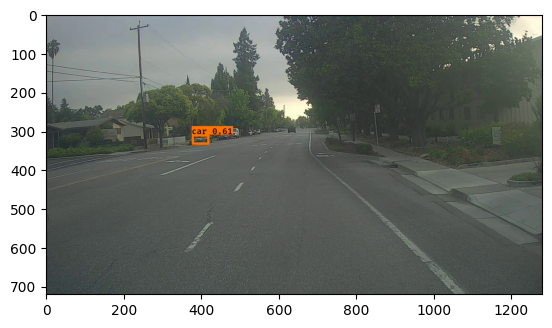

In [21]:
image_files = os.listdir("images")
n = 123

for image_file in image_files[:n]:
    out_scores, out_boxes, out_classes = predict(image_file)